### Structures
Definition of basic structures for computational graph

In [2]:
abstract type GraphNode end
abstract type Operator <: GraphNode end

struct Constant{T} <: GraphNode
    output :: T
end

mutable struct Variable <: GraphNode
    output :: Any
    gradient :: Any
    name :: String
    Variable(output; name="?") = new(output, nothing, name)
end

mutable struct ScalarOperator{F} <: Operator
    inputs :: Any
    output :: Any
    gradient :: Any
    name :: String
    ScalarOperator(fun, inputs...; name="?") = new{typeof(fun)}(inputs, nothing, nothing, name)
end

mutable struct BroadcastedOperator{F} <: Operator
    inputs :: Any
    output :: Any
    gradient :: Any
    name :: String
    BroadcastedOperator(fun, inputs...; name="?") = new{typeof(fun)}(inputs, nothing, nothing, name)
end

### Pretty-printing
It helps tracking what happens

In [3]:
import Base: show, summary
show(io::IO, x::ScalarOperator{F}) where {F} = print(io, "op ", x.name, "(", F, ")");
show(io::IO, x::BroadcastedOperator{F}) where {F} = print(io, "op.", x.name, "(", F, ")");
show(io::IO, x::Constant) = print(io, "const ", x.output)
show(io::IO, x::Variable) = begin
    print(io, "var ", x.name);
    print(io, "\n ┣━ ^ "); summary(io, x.output)
    print(io, "\n ┗━ ∇ ");  summary(io, x.gradient)
end

show (generic function with 278 methods)

### Graph building
At first we have a set of loosely-coupled graph nodes. The following procedures build a proper graph!

In [4]:
function visit(node::GraphNode, visited, order)
    if node ∈ visited
    else
        push!(visited, node)
        push!(order, node)
    end
    return nothing
end
    
function visit(node::Operator, visited, order)
    if node ∈ visited
    else
        push!(visited, node)
        for input in node.inputs
            visit(input, visited, order)
        end
        push!(order, node)
    end
    return nothing
end

function topological_sort(head::GraphNode)
    visited = Set()
    order = Vector()
    visit(head, visited, order)
    return order
end

topological_sort (generic function with 1 method)

### Forward pass

In [5]:
reset!(node::Constant) = nothing
reset!(node::Variable) = node.gradient = nothing
reset!(node::Operator) = node.gradient = nothing

compute!(node::Constant) = nothing
compute!(node::Variable) = nothing
compute!(node::Operator) =
    node.output = forward(node, [input.output for input in node.inputs]...)

function forward!(order::Vector)
    for node in order
        compute!(node)
        reset!(node)
    end
    return last(order).output
end

forward! (generic function with 1 method)

### Backward pass

In [6]:
update!(node::Constant, gradient) = nothing
update!(node::GraphNode, gradient) = if isnothing(node.gradient)
    node.gradient = gradient else node.gradient .+= gradient
end

function backward!(order::Vector; seed=1.0)
    result = last(order)
    result.gradient = seed
    @assert length(result.output) == 1 "Gradient is defined only for scalar functions"
    for node in reverse(order)
        backward!(node)
    end
    return nothing
end

function backward!(node::Constant) end
function backward!(node::Variable) end
function backward!(node::Operator)
    inputs = node.inputs
    gradients = backward(node, [input.output for input in inputs]..., node.gradient)
    for (input, gradient) in zip(inputs, gradients)
        update!(input, gradient)
    end
    return nothing
end

backward! (generic function with 4 methods)

### Implemented operations
Below is the list of supported operations on graph nodes

#### Scalar operators

In [7]:
import Base: ^
^(x::GraphNode, n::GraphNode) = ScalarOperator(^, x, n)
forward(::ScalarOperator{typeof(^)}, x, n) = return x^n
backward(::ScalarOperator{typeof(^)}, x, n, g) = tuple(g * n * x ^ (n-1), g * log(abs(x)) * x ^ n)

backward (generic function with 1 method)

In [8]:
import Base: sin
sin(x::GraphNode) = ScalarOperator(sin, x)
forward(::ScalarOperator{typeof(sin)}, x) = return sin(x)
backward(::ScalarOperator{typeof(sin)}, x, g) = tuple(g * cos(x))

backward (generic function with 2 methods)

#### Broadcasted operators
The operations act on vectors of values so, the gradients are computed as vector-jacobian-products.

In [9]:
import Base: *
import LinearAlgebra: mul!
# x * y (aka matrix multiplication)
*(A::GraphNode, x::GraphNode) = BroadcastedOperator(mul!, A, x)
forward(::BroadcastedOperator{typeof(mul!)}, A, x) = return A * x
backward(::BroadcastedOperator{typeof(mul!)}, A, x, g) = tuple(g * x', A' * g)

# x .* y (element-wise multiplication)
Base.Broadcast.broadcasted(*, x::GraphNode, y::GraphNode) = BroadcastedOperator(*, x, y)
forward(::BroadcastedOperator{typeof(*)}, x, y) = return x .* y
backward(node::BroadcastedOperator{typeof(*)}, x, y, g) = let
    𝟏 = ones(length(node.output))
    Jx = diagm(y .* 𝟏)
    Jy = diagm(x .* 𝟏)
    tuple(Jx' * g, Jy' * g)
end

backward (generic function with 4 methods)

In [10]:
Base.Broadcast.broadcasted(-, x::GraphNode, y::GraphNode) = BroadcastedOperator(-, x, y)
forward(::BroadcastedOperator{typeof(-)}, x, y) = return x .- y
backward(::BroadcastedOperator{typeof(-)}, x, y, g) = tuple(g,-g)

backward (generic function with 5 methods)

In [11]:
Base.Broadcast.broadcasted(+, x::GraphNode, y::GraphNode) = BroadcastedOperator(+, x, y)
forward(::BroadcastedOperator{typeof(+)}, x, y) = return x .+ y
backward(::BroadcastedOperator{typeof(+)}, x, y, g) = tuple(g, g)

backward (generic function with 6 methods)

In [12]:
import Base: sum
sum(x::GraphNode) = BroadcastedOperator(sum, x)
forward(::BroadcastedOperator{typeof(sum)}, x) = return sum(x)
backward(::BroadcastedOperator{typeof(sum)}, x, g) = let
    𝟏 = ones(length(x))
    J = 𝟏'
    tuple(J' * g)
end

backward (generic function with 7 methods)

In [13]:
Base.Broadcast.broadcasted(/, x::GraphNode, y::GraphNode) = BroadcastedOperator(/, x, y)
forward(::BroadcastedOperator{typeof(/)}, x, y) = return x ./ y
backward(node::BroadcastedOperator{typeof(/)}, x, y::Real, g) = let
    𝟏 = ones(length(node.output))
    Jx = diagm(𝟏 ./ y)
    Jy = (-x ./ y .^2)
    tuple(Jx' * g, Jy' * g)
end

backward (generic function with 8 methods)

In [14]:
import Base: max
Base.Broadcast.broadcasted(max, x::GraphNode, y::GraphNode) = BroadcastedOperator(max, x, y)
forward(::BroadcastedOperator{typeof(max)}, x, y) = return max.(x, y)
backward(::BroadcastedOperator{typeof(max)}, x, y, g) = let
    Jx = diagm(isless.(y, x))
    Jy = diagm(isless.(x, y))
    tuple(Jx' * g, Jy' * g)
end

backward (generic function with 9 methods)

## Testing area!
Below we will perform few tests.

In [15]:
x = Variable(5.0, name="x")
two = Constant(2.0)
squared = x^two
sine = sin(squared)

order = topological_sort(sine)

4-element Vector{Any}:
 var x
 ┣━ ^ Float64
 ┗━ ∇ Nothing
 const 2.0
 op ?(typeof(^))
 op ?(typeof(sin))

In [16]:
y = forward!(order)

-0.13235175009777303

In [17]:
backward!(order)

In [18]:
x.gradient

9.912028118634735

In [19]:
A = Variable([1.0 2.0; 3.0 4.0])
B = Constant([5.0 6.0; 7.0 8.0])

C = A * B
order = topological_sort(C)

3-element Vector{Any}:
 var ?
 ┣━ ^ 2×2 Matrix{Float64}
 ┗━ ∇ Nothing
 const [5.0 6.0; 7.0 8.0]
 op.?(typeof(mul!))

In [21]:
y = forward!(order)

2×2 Matrix{Float64}:
 19.0  22.0
 43.0  50.0

In [22]:
backward!(order)

AssertionError: AssertionError: Gradient is defined only for scalar functions

### The simplest multilayer-perceptron

In [1]:
include("secret-sauce.jl") # defines σ and ^

SystemError: SystemError: opening file "/home/sebastian/.julia/dev/autodif/docs/secret-sauce.jl": No such file or directory

In [ ]:
using LinearAlgebra
Wh  = Variable(randn(10,2), name="wh")
Wo  = Variable(randn(1,10), name="wo")
x = Variable([1.98, 4.434], name="x")
y = Variable([0.064], name="y")
losses = Float64[]

function dense(w, b, x, activation) return activation(w * x .+ b) end
function dense(w, x, activation) return activation(w * x) end
function dense(w, x) return w * x end

function mean_squared_loss(y, ŷ)
    return Constant(0.5) .* (y .- ŷ) .^ Constant(2)
end

function net(x, wh, wo, y)
    x̂ = dense(wh, x, σ)
    x̂.name = "x̂"
    ŷ = dense(wo, x̂)
    ŷ.name = "ŷ"
    E = mean_squared_loss(y, ŷ)
    E.name = "loss"

    return topological_sort(E)
end
graph = net(x, Wh, Wo, y)
forward!(graph)
backward!(graph)

for (i,n) in enumerate(graph)
    print(i, ". "); println(n)
end

1. const 0.5
2. var y
 ┣━ ^ 1-element Vector{Float64}
 ┗━ ∇ 1×1 Matrix{Float64}
3. var wo
 ┣━ ^ 1×10 Matrix{Float64}
 ┗━ ∇ 1×10 Matrix{Float64}
4. var wh
 ┣━ ^ 10×2 Matrix{Float64}
 ┗━ ∇ 10×2 Matrix{Float64}
5. var x
 ┣━ ^ 2-element Vector{Float64}
 ┗━ ∇ 2×1 Matrix{Float64}
6. op.?(typeof(mul!))
7. op.x̂(typeof(σ))
8. op.ŷ(typeof(mul!))
9. op.?(typeof(-))
10. const 2
11. op.?(typeof(^))
12. op.loss(typeof(*))


### Manual derivatives for comparison

In [ ]:
eye(n) = diagm(ones(n))
Eŷ  = graph[8].output - y.output #ŷ
ŷȳ  = graph[8].output |> length |> eye #ŷ
ȳWo = graph[7].output |> transpose #x̂
x̄Wh = graph[5].output |> transpose #x
ȳx̂  = graph[3].output |> transpose #Wo
x̂x̄  = graph[7].output .* (1.0 .- graph[7].output) |> diagm #x̂
Eȳ  = ŷȳ * Eŷ
Ex̂  = ȳx̂ * Eȳ
Ex̄  = x̂x̄ * Ex̂
EWo = Eȳ * ȳWo
EWh = Ex̄ * x̄Wh
nothing

In [ ]:
EWh

10×2 Matrix{Float64}:
  0.00551034    0.0123398
  0.108218      0.242342
  0.798858      1.78896
 -1.48537      -3.32632
 -0.323381     -0.724177
 -0.00825935   -0.0184959
  0.000655784   0.00146856
  0.0619627     0.138759
  0.11787       0.263958
 -0.000112812  -0.00025263

In [ ]:
currentloss = forward!(graph)
backward!(graph)
Wh.output -= 0.01Wh.gradient
Wo.output -= 0.01Wo.gradient
println("Current loss: ", currentloss)
push!(losses, first(currentloss))


Current loss: [2.4072847540231908]


1-element Vector{Float64}:
 2.4072847540231908

In [ ]:
Wh.gradient

10×2 Matrix{Float64}:
  0.00551034    0.0123398
  0.108218      0.242342
  0.798858      1.78896
 -1.48537      -3.32632
 -0.323381     -0.724177
 -0.00825935   -0.0184959
  0.000655784   0.00146856
  0.0619627     0.138759
  0.11787       0.263958
 -0.000112812  -0.00025263

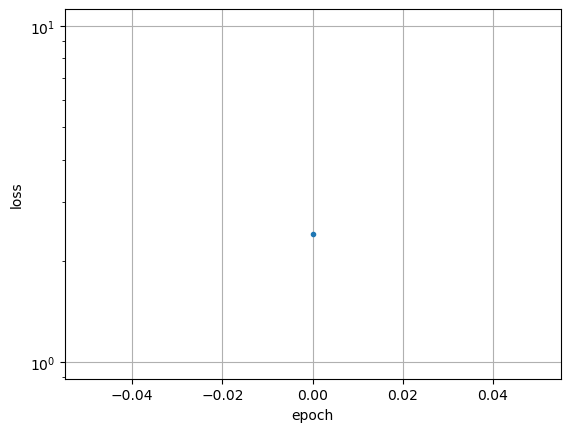

In [ ]:
using PyPlot
semilogy(losses, ".")
xlabel("epoch")
ylabel("loss")
grid()

In [ ]:
softmax(x::GraphNode) = BroadcastedOperator(softmax, x)
forward(::BroadcastedOperator{typeof(softmax)}, x) = return exp.(x) ./ sum(exp.(x))
backward(node::BroadcastedOperator{typeof(softmax)}, x, g) = let
    y = node.output
    J = diagm(y) .- y * y'
    tuple(J' * g)
end

backward (generic function with 12 methods)

In [ ]:
rosenbrock(x, y) = (Constant(1.0) .- x .* x) .+ Constant(100.0) .* (y .- x .* x) .* (y .- x .* x)

rosenbrock (generic function with 1 method)

In [ ]:
x = Variable([0.], name="x")
y = Variable([0.], name="y")
graph = topological_sort(rosenbrock(x, y))

13-element Vector{Any}:
 const 1.0
 var x
 ┣━ ^ 1-element Vector{Float64}
 ┗━ ∇ Nothing
 op.?(typeof(*))
 op.?(typeof(-))
 const 100.0
 var y
 ┣━ ^ 1-element Vector{Float64}
 ┗━ ∇ Nothing
 op.?(typeof(*))
 op.?(typeof(-))
 op.?(typeof(*))
 op.?(typeof(*))
 op.?(typeof(-))
 op.?(typeof(*))
 op.?(typeof(+))

In [ ]:
v  = -1:.1:+1
n  = length(v)
z  = zeros(n, n)
dz = zeros(n, n, 2)
for i=1:n, j=1:n
    x.output .= v[i]
    y.output .= v[j]
    z[i,j] = first(forward!(graph)); backward!(graph)
    dz[i,j,1] = first(x.gradient)
    dz[i,j,2] = first(y.gradient)
end


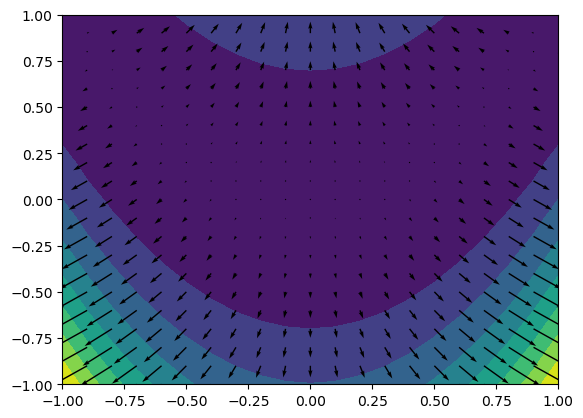

PyObject <matplotlib.quiver.Quiver object at 0x13be67340>

In [ ]:
using PyPlot
xv = repeat(v, 1, n)
yv = repeat(v',n, 1)
contourf(xv, yv, z)
quiver(xv, yv, dz[:,:,1], dz[:,:,2])